In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cabbage_df = pd.read_excel("data-files/양배추_가격.xlsx", engine='openpyxl')

In [3]:
cabbage_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16568 entries, 0 to 16567
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     16568 non-null  object 
 1   거래단위     16568 non-null  object 
 2   평균가격     16568 non-null  object 
 3   총거래물량    16568 non-null  float64
 4   총거래금액    16568 non-null  int64  
 5   도매시장     16568 non-null  object 
 6   도매법인     16568 non-null  object 
 7   품목       16568 non-null  object 
 8   품종       16568 non-null  object 
 9   산지-광역시도  16568 non-null  object 
 10  산지-시군구   16568 non-null  object 
 11  등급       16568 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.5+ MB


In [4]:
cabbage_df['DATE'] = pd.to_datetime(cabbage_df['DATE'], format='%Y-%m')

In [5]:
cabbage_df['산지-시군구'].unique()

array(['강원도', '정선군', '평창군', '삼척시', '제주시', '서산시', '횡성군', '전라남도', '괴산군',
       '무안군', '홍천군', '해남군', '충청남도', '보은군', '청원군', '-', '청주시', '춘천시',
       '태백시', '김천시', '광주광역시', '강릉시', '서울특별시', '영월군', '부산광역시', '제주도',
       '창녕군', '송파구', '창원시', '진해시', '경상북도', '태안군', '고창군', '인제군', '중구',
       '장수군', '봉화군', '예산군', '강서구', '양구군', '익산시', '동구', '전주시', '논산시',
       '당진시', '서구', '정읍시', '진도군', '홍성군', '부안군', '중국', '경기도', '천안시',
       '대구광역시', '포천시', '마산시', '원주시', '청송군', '평택시', '사상구', '달성군', '강남구',
       '무주군', '영양군', '안동시', '포항시', '남제주군', '고흥군', '김제시', '구리시', '공주시',
       '상주시', '경상남도', '김해시', '제천시', '완주군', '여주군', '임실군', '보성군', '남해군',
       '광양시', '남원시', '세종시', '북구', '기장군', '충주시', '옥천군', '구미시', '북제주군',
       '고양시', '계룡시', '대덕구', '영암군', '경산시', '파주시', '영광군', '김포시', '진주시',
       '고령군', '아산시', '담양군', '함안군', '단양군', '영덕군', '경주시', '칠곡군', '화성시',
       '진안군', '철원군', '계양구', '남양주시', '울산광역시', '청도군', '순천시', '양주시', '강화군',
       '증평군', '신안군', '거제시', '안성시', '관악구', '음성군', '대전광역시', '서귀포시', '하동군',
       '안산시', 

In [6]:
cabbage_df['도매시장'].unique()

array(['구리도매시장', '대전오정도매', '인천구월도매', '서울강서도매', '수원도매시장', '광주각화도매',
       '순천도매시장', '대전노은도매', '안양도매시장', '전주도매시장', '광주서부도매', '청주도매시장',
       '원주도매시장', '천안도매시장', '안산도매시장', '부산엄궁도매', '창원내서도매시장', '창원팔용도매시장',
       '춘천도매시장', '대구북부도매', '부산반여도매', '정읍도매시장', '진주도매시장', '인천삼산도매',
       '울산도매시장', '서울가락도매', '포항도매시장', '강릉도매시장', '충주도매시장', '구미도매시장'],
      dtype=object)

In [7]:
cabbage_df['산지-광역시도'].unique()

array(['강원도', '제주', '충청남도', '전라남도', '충북', '전남', '강원', '충청북도', '충남', '-',
       '경북', '광주광역시', '서울특별시', '부산광역시', '제주도', '경상남도', '서울', '경상북도', '경남',
       '전북', '부산', '대구', '광주', '전라북도', '중국', '경기도', '대구광역시', '경기', '인천',
       '세종시', '대전광역시', '울산광역시', '인천광역시', '울산', '대전', '수입산'], dtype=object)

In [8]:
# 산지-광역시도 기준 디렉토리

region_sum = {
    '충남': '충청남도', 
    '강원': '강원도', 
    '제주':'제주도', 
    '전남' : '전라남도',
    '전북' : '전라북도', 
    '강원' : '강원도',
    '충북' : '충청북도',
    '부산' : '부산광역시',
    '경남' : '경상남도',
    '서울' : '서울특별시',
    '광주' : '광주광역시', 
    '경북' : '경상북도',
    '경기' : '경기도',
    '인천' : '인천광역시',
    '대구' : '대구광역시',
    '울산' : '울산광역시',
    '대전' : '대전광역시'
}

In [9]:
# 시각화 하기 위해서 평균가격, 총거래물량, 도매시장, 산지-광역시도 컬럼만 가져오기

cabbage_df['평균가격'] = pd.to_numeric(cabbage_df['평균가격'], errors='coerce')
cabbage_df['총거래물량'] = pd.to_numeric(cabbage_df['총거래물량'], errors='coerce')


cabbage_df_cleaned = cabbage_df.dropna(subset=['평균가격', '총거래물량', '도매시장', '산지-광역시도'])


# 가중치
cabbage_df_cleaned['weighted_price'] = (
    cabbage_df_cleaned['평균가격'] * cabbage_df_cleaned['총거래물량']
)


# 산지-광역시도 데이터를 위에서 만든 기준 디렉토리를 이용하여 변경
# 충북 = 충청북도, 충남 = 충청남도 등

cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)


# 도매시장별로 그룹화
weighted_avg_market = (
    cabbage_df_cleaned.groupby(['DATE', '도매시장']).apply(
        lambda g: g['weighted_price'].sum() / g['총거래물량'].sum()
    ).reset_index(name='가중평균가격')
)

# 광역시도별로 그룹화
weighted_avg_ragion = (
    cabbage_df_cleaned.groupby(['DATE', '산지-광역시도'])
    .apply(lambda g: g['weighted_price'].sum() / g['총거래물량'].sum())
    .reset_index(name='가중평균가격')
)

C:\Users\human\AppData\Local\Temp\ipykernel_2220\3448614163.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['weighted_price'] = (
C:\Users\human\AppData\Local\Temp\ipykernel_2220\3448614163.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cabbage_df_cleaned['산지-광역시도'] = cabbage_df_cleaned['산지-광역시도'].replace(region_sum)
C:\Users\human\AppData\Local\Temp\ipykernel_2220\3448614163.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

In [10]:
weighted_avg_market['도매시장'].unique()

array(['강릉도매시장', '광주각화도매', '광주서부도매', '구리도매시장', '구미도매시장', '대구북부도매',
       '대전노은도매', '대전오정도매', '부산반여도매', '부산엄궁도매', '서울강서도매', '수원도매시장',
       '순천도매시장', '안산도매시장', '울산도매시장', '원주도매시장', '인천구월도매', '전주도매시장',
       '진주도매시장', '창원내서도매시장', '창원팔용도매시장', '천안도매시장', '춘천도매시장', '포항도매시장',
       '서울가락도매', '충주도매시장', '인천삼산도매', '청주도매시장', '안양도매시장', '정읍도매시장'],
      dtype=object)

<Figure size 1400x800 with 0 Axes>

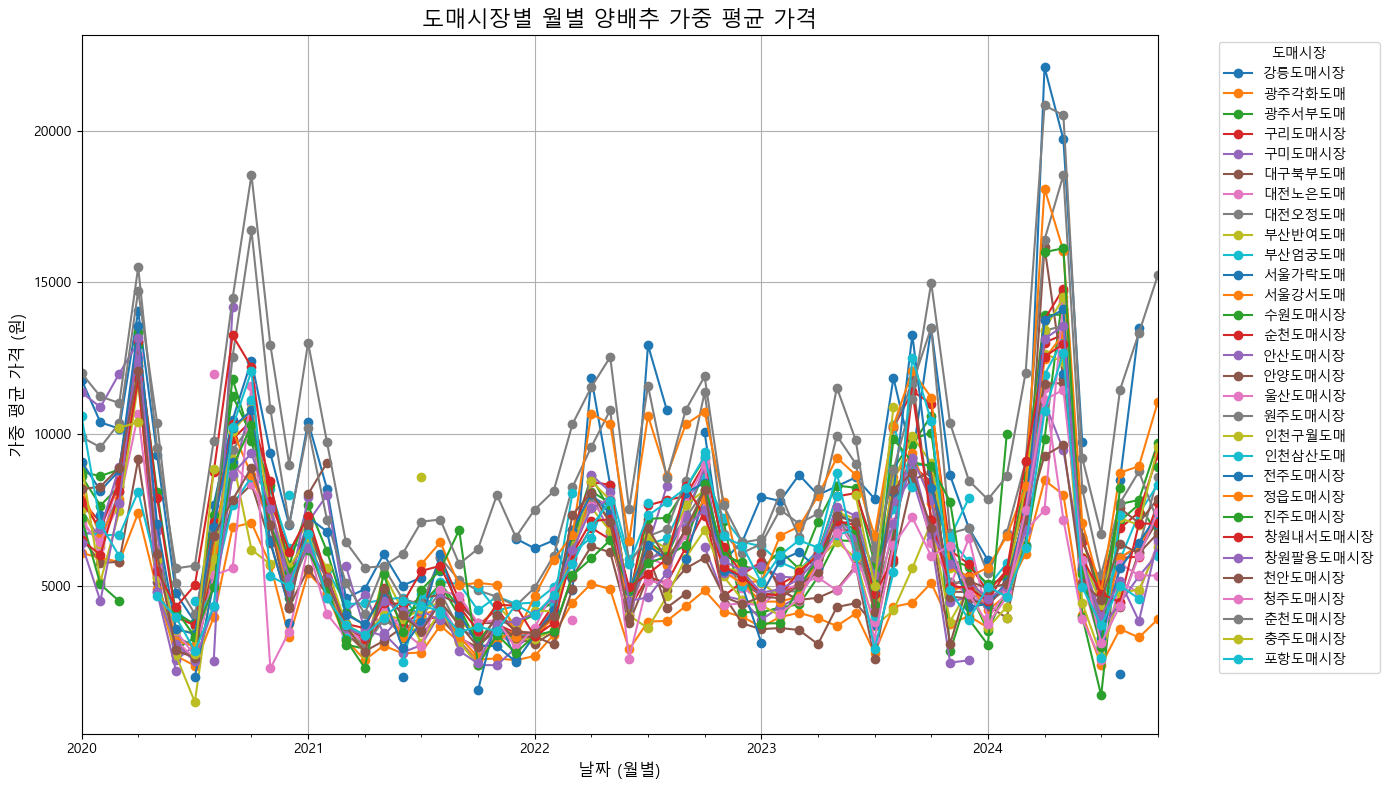

In [11]:
#도매시장별 월별 가격 시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False


cabbage_market_pivot = weighted_avg_market.pivot(index='DATE', columns='도매시장', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_market_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('도매시장별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='도매시장', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [12]:
cabbage_df_cleaned['산지-광역시도'].unique()

array(['강원도', '제주도', '충청남도', '전라남도', '충청북도', '-', '경상북도', '광주광역시',
       '서울특별시', '부산광역시', '경상남도', '전라북도', '대구광역시', '중국', '경기도', '인천광역시',
       '세종시', '대전광역시', '울산광역시', '수입산'], dtype=object)

<Figure size 1400x800 with 0 Axes>

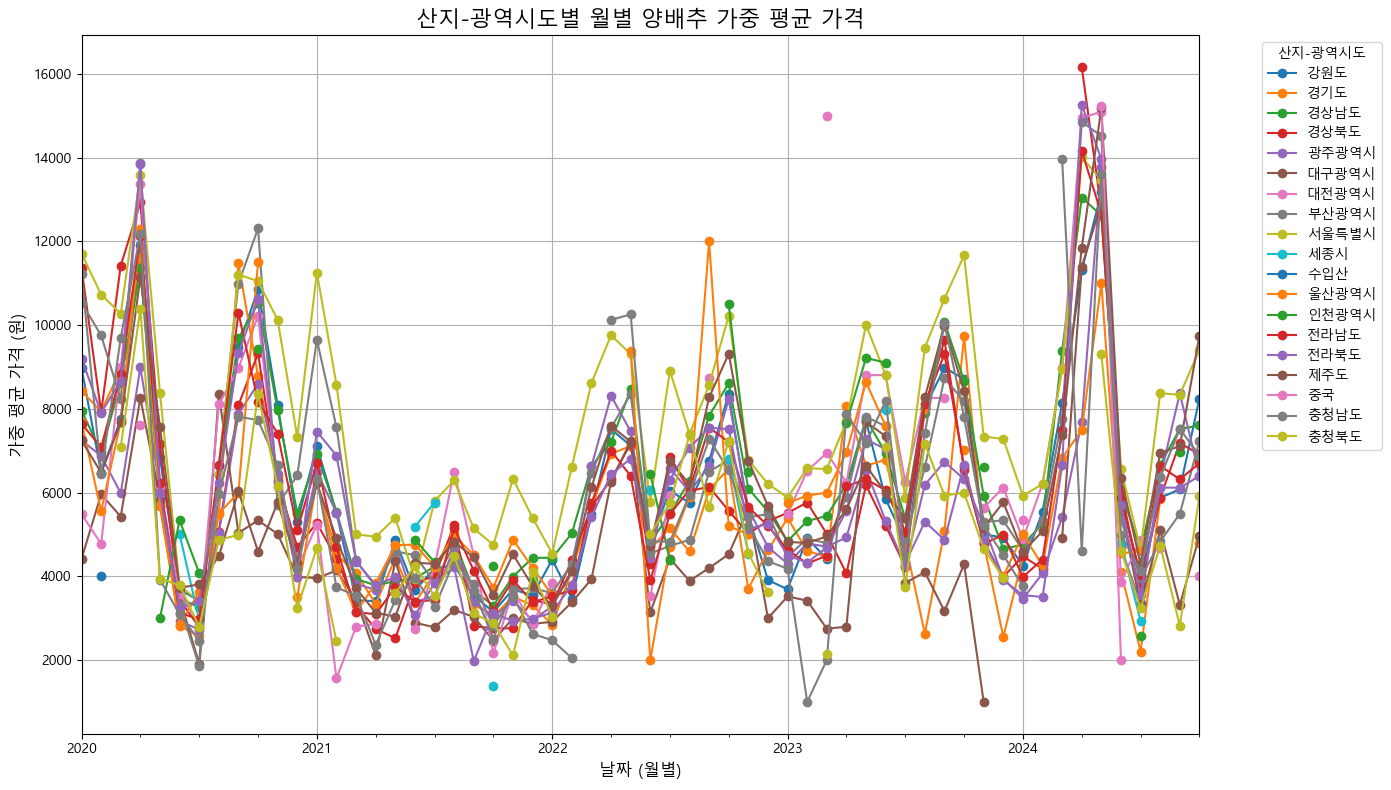

In [13]:
#광역시도별 월별 가격시각화

import matplotlib.pyplot as plt

#한글
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

weighted_avg_ragion = weighted_avg_ragion[weighted_avg_ragion['산지-광역시도'] != '-']

cabbage_ragion_pivot = weighted_avg_ragion.pivot(index='DATE', columns='산지-광역시도', values='가중평균가격')

plt.figure(figsize=(14, 8))
cabbage_ragion_pivot.plot(kind='line', figsize=(14, 8), marker='o')

plt.title('산지-광역시도별 월별 양배추 가중 평균 가격', fontsize=16)
plt.xlabel('날짜 (월별)', fontsize=12)
plt.ylabel('가중 평균 가격 (원)', fontsize=12)
plt.grid(True)
plt.legend(title='산지-광역시도', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [14]:
# cabbage_df_cleaned.to_csv("data-files/cabbage_df_cleaned.csv", index=False)

In [15]:
# 기후 데이터 가져오기

weather_final = pd.read_csv("data-files/weather_final.csv")

In [16]:
weather_final['DATE'] = pd.to_datetime(weather_final['DATE'], format='%Y-%m')

In [17]:
cabbage_df_cleaned

,DATE,거래단위,평균가격,총거래물량,총거래금액,도매시장,도매법인,품목,품종,산지-광역시도,산지-시군구,등급,weighted_price
0,2024-10-01,10kg그물망,9095.258005,385070.0,350231100,구리도매시장,농협구리(공),양배추,양배추(일반),강원도,강원도,특,3.502311e+09
1,2024-10-01,10kg그물망,9708.371697,375790.0,364830900,대전오정도매,대전청과,양배추,양배추(일반),강원도,정선군,.,3.648309e+09
2,2024-10-01,10kg그물망,6569.604190,185190.0,121662500,구리도매시장,인터넷청과,양배추,양배추(일반),강원도,정선군,특,1.216625e+09
3,2024-10-01,10kg그물망,7937.896750,130750.0,103788000,구리도매시장,구리청과,양배추,양배추(일반),강원도,평창군,등외,1.037880e+09
4,2024-10-01,10kg그물망,6517.980576,114290.0,74494000,구리도매시장,인터넷청과,양배추,양배추(일반),강원도,삼척시,특,7.449400e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16563,2020-01-01,10kg그물망,1000.000000,40.0,4000,광주서부도매,두레청과,양배추,양배추(일반),전라남도,진도군,상,4.000000e+04
16564,2020-01-01,10kg그물망,18000.000000,20.0,36000,인천구월도매,구월원협(공),양배추,양배추(일반),전라남도,나주시,특,3.600000e+05
16565,2020-01-01,10kg그물망,12000.000000,20.0,24000,전주도매시장,전주원협(공),양배추,양배추(일반),전라북도,전주시,보통,2.400000e+05
16566,2020-01-01,10kg그물망,1300.000000,20.0,2600,순천도매시장,순천원협(공),양배추,양배추(일반),제주도,북제주군,등외,2.600000e+04


In [18]:
merged_df = cabbage_df_cleaned.merge(
    weather_final,
    left_on=['DATE', '산지-광역시도'],
    right_on=['DATE', '광역시도'],
    how='left'
)

In [19]:
# merged_df.to_csv("data-files/merged_df.csv", index = False)

In [20]:
merged_df['DATE'] = merged_df['DATE'].dt.to_period('M').dt.to_timestamp()

In [21]:
merged_df = merged_df.drop(columns=['총거래금액', '산지-시군구', '품목', '품종', '도매법인'])
merged_df = merged_df[merged_df['등급'] == '특']

In [22]:
merged_df = merged_df[~merged_df['산지-광역시도'].isin(['중국', '-'])]

In [23]:
merged_df

,DATE,거래단위,평균가격,총거래물량,도매시장,산지-광역시도,등급,weighted_price,광역시도,평균기온,평균풍속,평균강수량
0,2024-10-01,10kg그물망,9095.258005,385070.0,구리도매시장,강원도,특,3.502311e+09,강원도,12.93,1.56,130.36
2,2024-10-01,10kg그물망,6569.604190,185190.0,구리도매시장,강원도,특,1.216625e+09,강원도,12.93,1.56,130.36
4,2024-10-01,10kg그물망,6517.980576,114290.0,구리도매시장,강원도,특,7.449400e+08,강원도,12.93,1.56,130.36
5,2024-10-01,10kg그물망,10033.179519,112690.0,인천구월도매,제주도,특,1.130639e+09,제주도,18.36,3.63,194.00
11,2024-10-01,10kg그물망,6822.118789,76270.0,구리도매시장,충청남도,특,5.203230e+08,충청남도,16.32,2.29,92.38
...,...,...,...,...,...,...,...,...,...,...,...,...
16551,2020-01-01,10kg그물망,3066.666667,150.0,광주서부도매,전라남도,특,4.600000e+05,전라남도,4.65,2.77,77.65
16552,2020-01-01,10kg그물망,9500.000000,120.0,창원내서도매시장,서울특별시,특,1.140000e+06,서울특별시,1.85,1.35,55.52
16555,2020-01-01,10kg그물망,10500.000000,60.0,진주도매시장,제주도,특,6.300000e+05,제주도,6.06,3.90,163.16
16558,2020-01-01,10kg그물망,18000.000000,20.0,인천구월도매,전라남도,특,3.600000e+05,전라남도,4.65,2.77,77.65


In [36]:
# 각 재배 방식에 대한 파종 시기와 수확 시기 정의
cultivation_periods = {
    "봄재배": {"planting": [3, 4, 5, 6], "harvesting": [6, 7]},
    "가을재배": {"planting": [7, 8, 9, 10], "harvesting": [10, 11]},
    "월동재배": {"planting": [9, 10, 11], "harvesting": [3, 4, 5]},
    "여름재배": {"planting": [5, 6, 7, 8], "harvesting": [9]}
}

# 각 재배 방식에 대한 상관관계 결과를 저장할 딕셔너리
results = {}

for crop, periods in cultivation_periods.items():
    planting_months = periods['planting']  # 파종 시기 월 정의
    harvesting_months = periods['harvesting']  # 수확 시기 월 정의
    
    # 파종 시기 기후 데이터를 연도별로 집계
    planting_climate_data = (
        merged_df[merged_df['DATE'].dt.month.isin(planting_months)]
        .groupby(merged_df['DATE'].dt.year)
        .mean(numeric_only=True)[['평균기온', '평균풍속', '평균강수량']]
        .rename_axis('YEAR')  # 연도를 인덱스로 사용
    )
    
    # 수확 시기 총 거래물량을 연도별로 집계
    harvesting_transaction_data = (
        merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]
        .groupby(merged_df['DATE'].dt.year)['총거래물량']
        .sum()
        .rename_axis('YEAR')  # 연도를 인덱스로 사용
    )
    
    # 상관관계 분석을 위해 데이터를 병합
    combined_analysis_data = planting_climate_data.merge(
        harvesting_transaction_data,
        left_index=True,
        right_index=True
    )
    
    # 상관관계 계산
    correlation_results = combined_analysis_data.corr().loc['총거래물량'].drop('총거래물량')
    results[crop] = correlation_results  # 결과 저장

# 결과를 하나의 데이터프레임으로 변환하여 표시
correlation_results_df = pd.DataFrame(results).transpose()

In [37]:
correlation_results_df

,평균기온,평균풍속,평균강수량
봄재배,-0.132670,0.547960,-0.795771
가을재배,-0.603615,-0.740804,-0.353241
월동재배,-0.487433,0.473492,-0.648265
여름재배,-0.271701,-0.048232,-0.716378


In [38]:
import pandas as pd
# Dictionary to store correlation results for each cultivation type
results = {}

for crop, periods in cultivation_periods.items():
    planting_months = periods['planting']
    harvesting_months = periods['harvesting']
    
    # Aggregating planting data
    planting_data = (
        merged_df[merged_df['DATE'].dt.month.isin(planting_months)]
        .groupby(merged_df['DATE'].dt.year)
        .mean(numeric_only=True)[['평균가격']]
        .rename_axis('YEAR')
    )
    
    # Aggregating harvesting data
    harvesting_data = (
        merged_df[merged_df['DATE'].dt.month.isin(harvesting_months)]
        .groupby(merged_df['DATE'].dt.year)['총거래물량']
        .sum()
        .rename_axis('YEAR')
    )
    
    # Merging planting and harvesting data
    combined_data = planting_data.merge(
        harvesting_data,
        left_index=True,
        right_index=True
    )
    
    # Calculating correlations
    correlation_results = combined_data.corr().loc['총거래물량'].drop('총거래물량')
    results[crop] = correlation_results

# Converting results into a DataFrame
correlation_results_df = pd.DataFrame(results).transpose()

In [39]:
correlation_results_df

,평균가격
봄재배,-0.422614
가을재배,-0.270507
월동재배,-0.691609
여름재배,-0.647840
